# Соберем сверточную нейронную сеть LiNet5

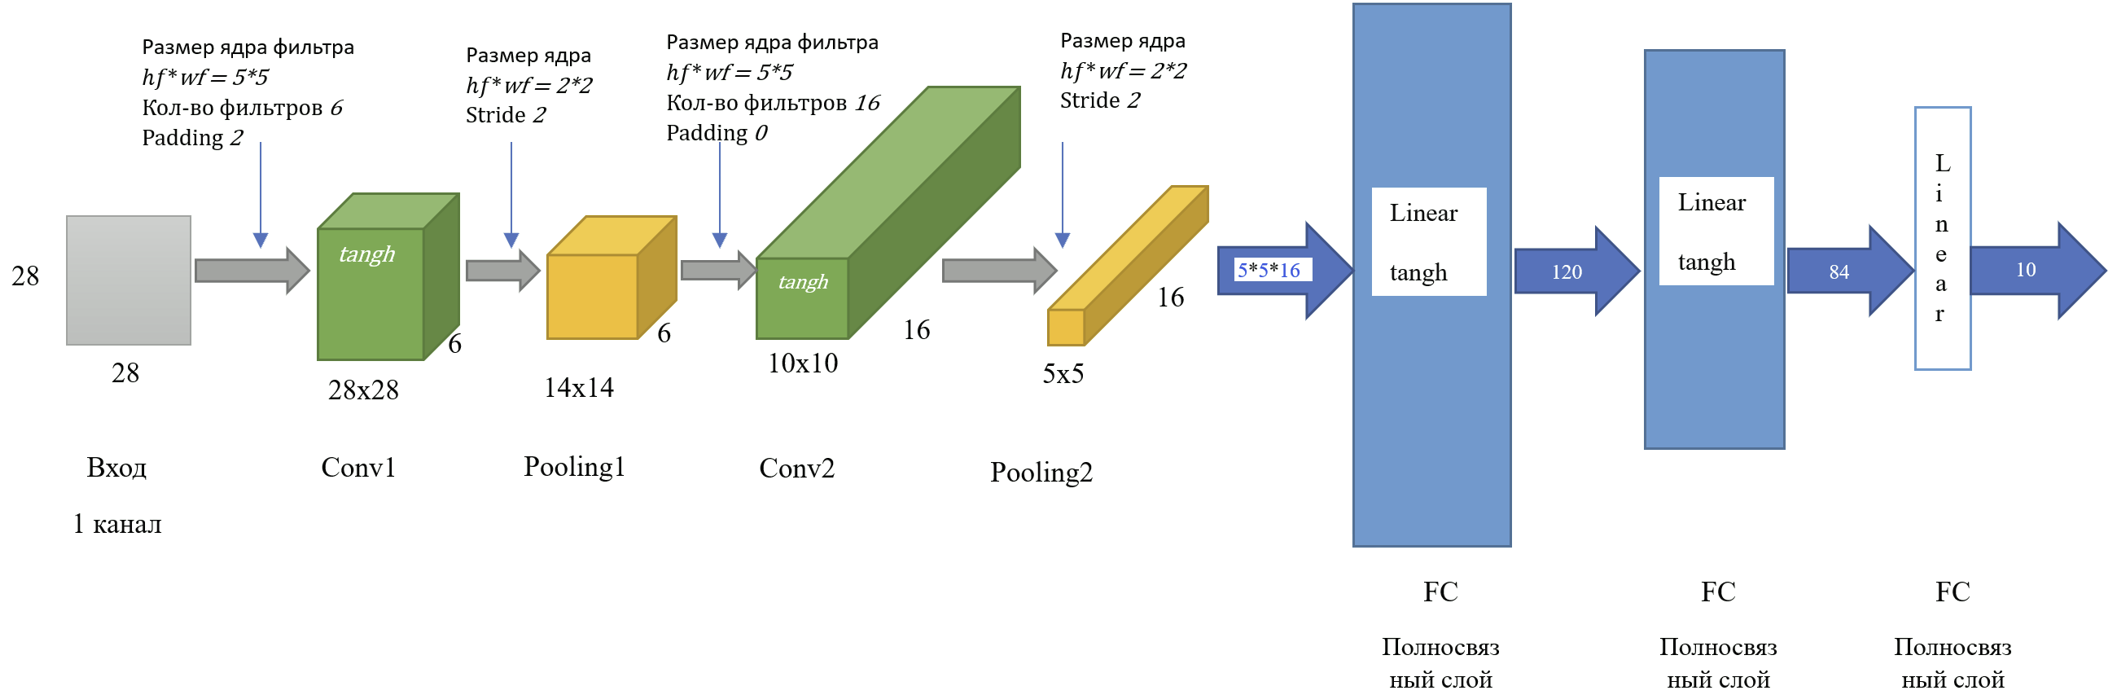


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет $28 \times 28$, функция активации $tangh$;

**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет $14 \times 14$, функция активации $AvgPooling$;

**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет $10 \times 10$, функция активации $tangh$;

**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет $5 \times 5$, функция активации $AvgPooling$;

**Слой FC** представляет собой полносвязанный слой, вход $5 \times 5 \times 16$ нейронов (признаков), выход $120$ нейронов, функция активации $tangh$;

**Слой FC** представляет собой полносвязанный слой, вход $120$ нейронов (признаков), выход $84$ нейрона, функция активации $tangh$;

**Слой FC** представляет собой полносвязанный слой, вход $84$ нейронов (признаков), выход $10$ нейронов;



In [ ]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
# это для cuda .
#torch.cuda.memory_summary(device=None, abbreviated=True)

In [ ]:
# это для cuda. принудительно освобождение памяти, что иногда, но очень редко, помогает решить проблему с отказом
# cuda использовать память
#import gc
#gc.collect()

#torch.cuda.empty_cache()

In [ ]:
# будем использовать встроенные датасеты торча.
# полный список - тут https://pytorch.org/vision/stable/datasets.html


import torchvision.datasets

In [ ]:
# загружаем сразу в трайн и тест
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


In [ ]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

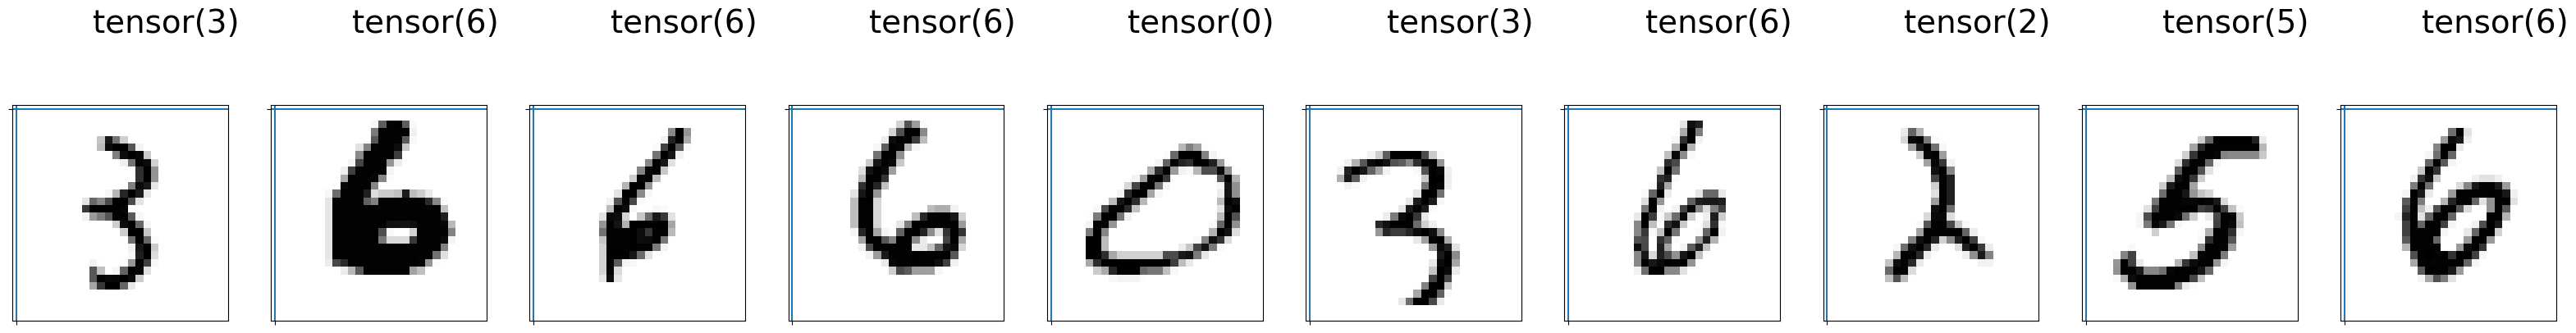

In [ ]:
# посмотрим, что пришло

import numpy as np
import matplotlib.pyplot as plt

# посмотрим какие-то произвольные изображения из датасета
count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=28)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [ ]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(60000, 10000)

image:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 

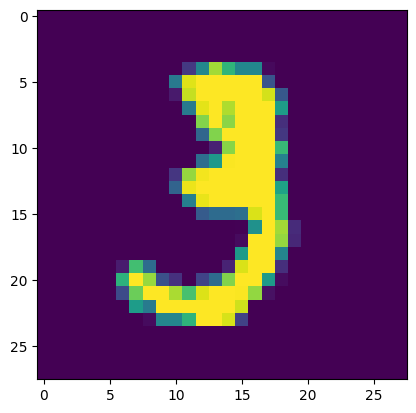

tensor(3)


In [ ]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 10

# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")

# а так их видим мы
plt.imshow(X_train[im_number, :, :])

plt.show()
print(y_train[im_number])

In [ ]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

In [ ]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([60000, 28, 28])  ---- станет torch.Size([60000, 1, 28, 28])
# и все значения - во float

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
X_test.shape

torch.Size([10000, 1, 28, 28])

In [ ]:
# Определяем класс, которые и будет представлять нашу нейронку
# какие слои - см описание вначале блокнота

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [ ]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

# ЕСЛИ ВЫ ОБУЧИТЕ НЕЙРОНКУ НА GPU или CPU ОНА ДЛЯ СВОЕЙ РАБОТЫ БУДЕТ ТРЕБОВАТЬ ИЛИ GPU, ИЛИ CPU
Поэтому не всегда возможно использование обучения на GPU просто потому, что сервер или компьютер пользователя не будет поддерживать расчеты на GPU

In [ ]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [ ]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.9745000004768372 
epoch1 - accuracy test 0.9807999730110168 
epoch2 - accuracy test 0.9856999516487122 
epoch3 - accuracy test 0.986299991607666 
epoch4 - accuracy test 0.9866999983787537 
epoch5 - accuracy test 0.9871999621391296 
epoch6 - accuracy test 0.9893999695777893 
epoch7 - accuracy test 0.9886999726295471 
epoch8 - accuracy test 0.9878000020980835 
epoch9 - accuracy test 0.9887999892234802 
epoch10 - accuracy test 0.9900999665260315 
epoch11 - accuracy test 0.9882999658584595 
epoch12 - accuracy test 0.9886999726295471 
epoch13 - accuracy test 0.9893999695777893 
epoch14 - accuracy test 0.9870999455451965 
epoch15 - accuracy test 0.989799976348877 
epoch16 - accuracy test 0.9889999628067017 
epoch17 - accuracy test 0.9883999824523926 
epoch18 - accuracy test 0.9876999855041504 
epoch19 - accuracy test 0.9893999695777893 
epoch20 - accuracy test 0.9894999861717224 
epoch21 - accuracy test 0.9875999689102173 
epoch22 - accuracy test 0.9869999885559082 


KeyboardInterrupt: 

In [ ]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



In [ ]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [ ]:
# сохраняем произвольное число из датасета (тензор) в файл
timg = X_train[0]

torch.save(timg,'tensor.pt')


In [ ]:
# смотрим размер тензора - изображения
timg.size()

In [ ]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()

# то есть нам нужен тензор размера [1,1,28,28]

In [ ]:
!pip install dill

In [ ]:
# вот так сохраняют модель с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [ ]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(lenet5, pickle_file)



In [ ]:
# считываем модель, сохраненную в dill

ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


In [ ]:
# смотрим тип модели
type(modelp)

In [ ]:
# смотрим, что за цифру считали
plt.imshow(test_data[0, :, :])
plt.show()

In [ ]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

In [ ]:
# проверяем
t_data.shape

In [ ]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [ ]:
# делаем предсказание
preds = modelp.forward(t_data)

In [ ]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

In [ ]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [ ]:
# смотрим, что предсказалось
print(prediction)

Цифра предсказана верно.


**Упражнение. Выберите случайным образом изображение из тестового набора и сделайте предсказание для него.**

In [ ]:
# Считываем модель, сохраненную в dill
ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

torch.save(X_train[1], 'tensor.pt')
# Загружаем тестовый набор данных
test_data = torch.load('tensor.pt')
print("Размер тестового набора:", test_data.shape)

# Выбираем случайное изображение из тестового набора
random_index = random.randint(0, len(test_data) - 1)
random_image = test_data[random_index]
print(f"Выбран индекс: {random_index}")

# Отображаем изображение
plt.imshow(test_data[0, :, :])
plt.show()

# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

# проверяем
t_data.shape

# Проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# Отправляем тензор-изображение на устройство
t_data = t_data.to(dev)

# делаем предсказание
preds = modelp.forward(t_data)

# Выводим предсказание (вектор вероятностей)
print(preds)

# Выбираем максимальную вероятность, как результат предсказания
prediction = np.argmax(preds.to('cpu').detach().numpy(), axis=1)

# Выводим предсказанный класс
print(f'Предсказанный класс: {prediction[0]}')

***Задание. Реализовать классификацию изображений на своем датасете.***

1. Выберите датасет для классификации изображений https://pytorch.org/vision/stable/datasets.html
2. Определите архитектуру нейросети и приведите ее описание (текстом или иным способом) в своей работе
3. Реализуйте выбранную архитектуру в виде класса
4. Обучите нейросеть
5. Постройте на одном графике кривые изменения функции потерь на тесте и обучении
6. Постройте график изменения выбранной метрики качества на тесте
7. Сохраните в файл одно изображение из тестовой выборки
8. Сохраните обученную нейросеть в файл
9. Загрузите изображение из файла
10. Загрузите нейросеть
11. Выполните предсказание с помощью загруженной из файла нейросети и оцените его правильность

100%|██████████| 18.2M/18.2M [00:11<00:00, 1.61MB/s]


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 280kB/s]


Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 1.66MB/s]


Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 6.87MB/s]
<ipython-input-1-51239450144d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(KMNIST_train.data)  # Преобразуем в тензор
<ipython-input-1-51239450144d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(KMNIST_train.targets)
<ipython-input-1-51239450144d>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(KMNIST_test.data)
<ipython-input-1-51239450144d>:29: UserWarning: To copy construct from a tensor, it is recommende

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



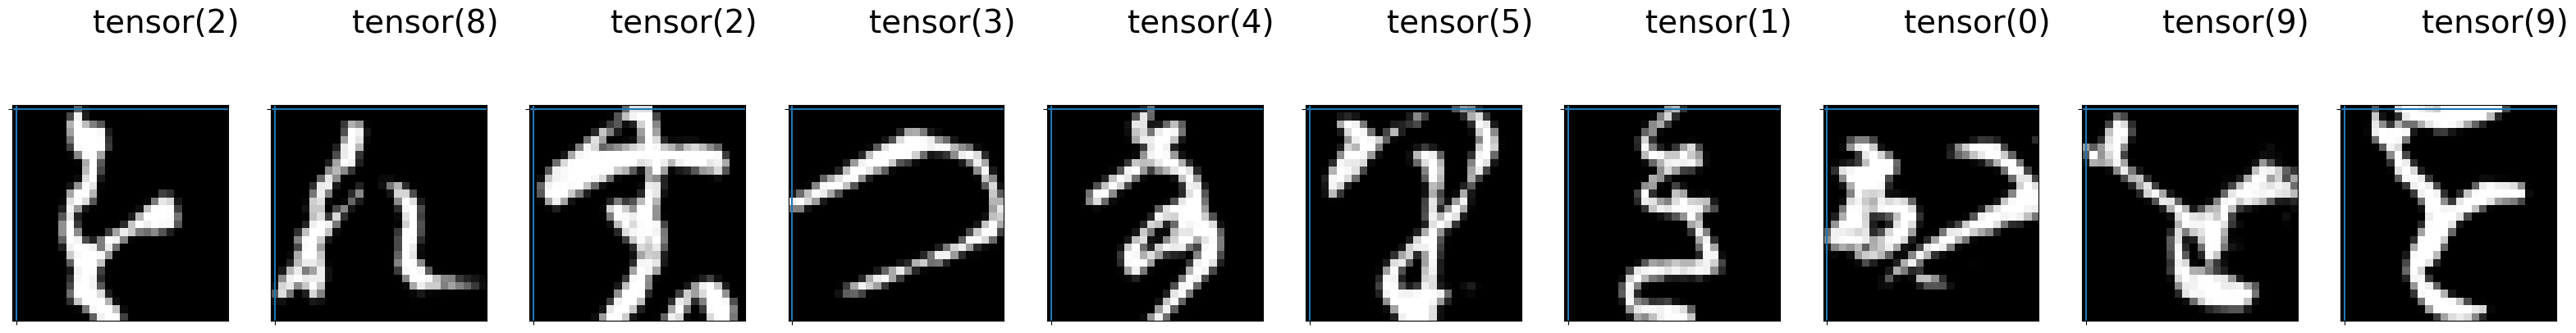

In [1]:
# Импортируем библиотеки
import torch
import random
import numpy as np
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Фиксируем случайные числа для воспроизводимости
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Определяем преобразования для KMNIST
transform = transforms.Compose([
    transforms.ToTensor()  # Переводим в тензор
])

# Загружаем KMNIST
KMNIST_train = torchvision.datasets.KMNIST('./', download=True, train=True, transform=transform)
KMNIST_test = torchvision.datasets.KMNIST('./', download=True, train=False, transform=transform)

# Формируем датасеты для обучения, тестирования, целевые переменные
X_train = torch.tensor(KMNIST_train.data)  # Преобразуем в тензор
y_train = torch.tensor(KMNIST_train.targets)
X_test = torch.tensor(KMNIST_test.data)
y_test = torch.tensor(KMNIST_test.targets)

# Посмотрим, что пришло
sample_size = 10  # Сколько картинок будем смотреть
plt.figure(figsize=(40, 20))

count = 0
for i in np.random.permutation(len(KMNIST_train))[:sample_size]:
    count += 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=KMNIST_train.targets[i], fontsize=28)  # .item() для вывода числа
    plt.imshow(KMNIST_train[i][0].permute(1, 2, 0).numpy(), cmap='gray')  # Черно-белое изображение
plt.show()

In [3]:
# Сколько изображений в трейне и тесте
print("Train samples:", len(y_train))
print("Test samples:", len(y_test))

# Нарисуем, с чем мы имеем дело
im_number = 10

# Вот как хранятся изображения в компьютере
print(f"Image tensor:\n{X_train[im_number, :, :]}")  # Для KMNIST (одноканальное изображение)

print("Label:", y_train[im_number])

# Посмотрим тип "картинок"
print("Type of image tensor:", type(X_train[10, :, :]))

# Проверяем размеры тензоров
print("Train tensor shape:", X_train.shape)  # (60000, 1, 28, 28)
print("Test tensor shape:", X_test.shape)   # (10000, 1, 28, 28)

# Приводим данные к float
X_train = X_train.float()
X_test = X_test.float()

print("Train tensor shape after conversion:", X_train.shape)  # Должно остаться (60000, 1, 28, 28)
print("Test tensor shape after conversion:", X_test.shape)   # Должно остаться (10000, 1, 28, 28)

Train samples: 60000
Test samples: 10000
Image tensor:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           9, 109, 142, 116,  91,  79,  21,   1,   0,   0,   0,   0,   

In [4]:
# Определяем класс, который будет представлять нашу нейросеть
class LeNet5(torch.nn.Module):
    # Конструктор. Определяем, какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)  # 1 канал для KMNIST
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5)  # Без padding
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(16 * 5 * 5, 120)  # Размер для KMNIST (28x28)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)  # 10 классов

    # Главная функция. Определяет порядок вызова слоев
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Разворачиваем тензор в вектор

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# Переменная — наша нейронка
lenet5 = LeNet5()

# Определяем, где будет обучаться наша CNN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Отправляем нейросеть на устройство
lenet5 = lenet5.to(device)

Original train tensor shape: torch.Size([60000, 28, 28])
Train tensor shape after adding channel dimension: torch.Size([60000, 1, 28, 28])
Original test tensor shape: torch.Size([10000, 28, 28])
Test tensor shape after adding channel dimension: torch.Size([10000, 1, 28, 28])
Epoch 0: Test Accuracy = 0.8532
Epoch 1: Test Accuracy = 0.9089
Epoch 2: Test Accuracy = 0.9190
Epoch 3: Test Accuracy = 0.9341
Epoch 4: Test Accuracy = 0.9372
Epoch 5: Test Accuracy = 0.9306
Epoch 6: Test Accuracy = 0.9388
Epoch 7: Test Accuracy = 0.9420
Epoch 8: Test Accuracy = 0.9408
Epoch 9: Test Accuracy = 0.9433
Epoch 10: Test Accuracy = 0.9398
Epoch 11: Test Accuracy = 0.9430
Epoch 12: Test Accuracy = 0.9365
Epoch 13: Test Accuracy = 0.9468
Epoch 14: Test Accuracy = 0.9394
Epoch 15: Test Accuracy = 0.9440
Epoch 16: Test Accuracy = 0.9472
Epoch 17: Test Accuracy = 0.9411
Epoch 18: Test Accuracy = 0.9436
Epoch 19: Test Accuracy = 0.9441
Epoch 20: Test Accuracy = 0.9460
Epoch 21: Test Accuracy = 0.9467
Epoch 22

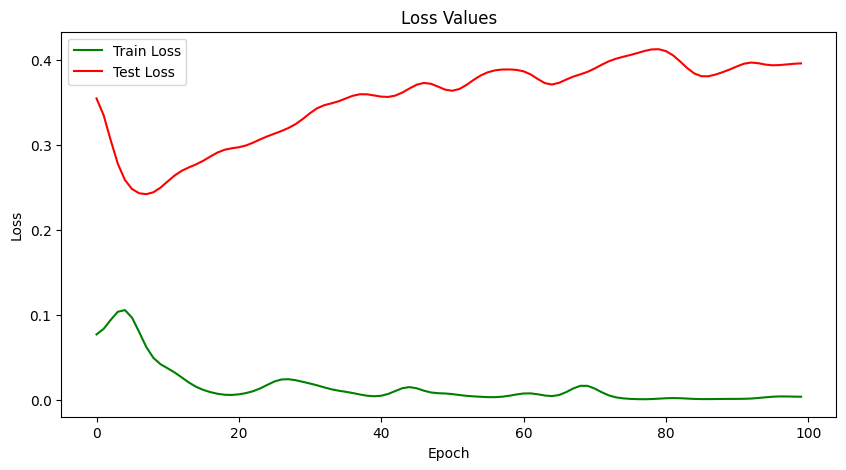

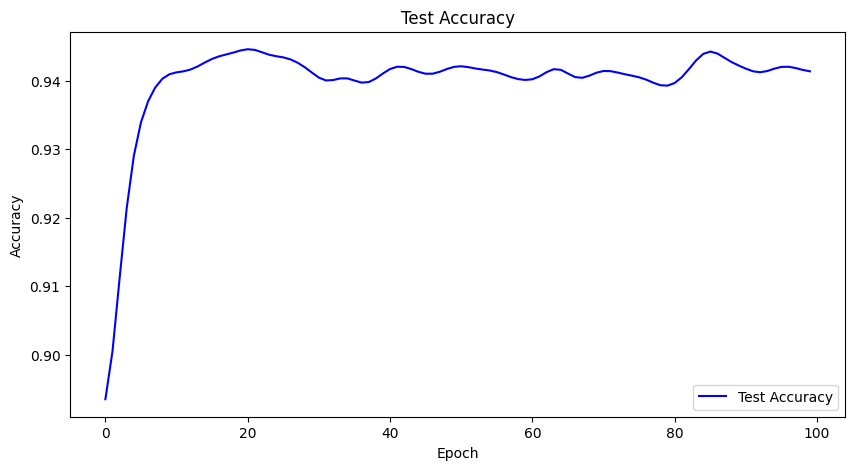

In [19]:
# Переменная — наша нейронка
lenet5 = LeNet5()

# Определяем, где будет обучаться наша CNN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Отправляем нейросеть на устройство
lenet5 = lenet5.to(device)

# Функция потерь — CrossEntropyLoss
loss = torch.nn.CrossEntropyLoss()

print("Original train tensor shape:", X_train.shape)
# Добавляем измерение для каналов
X_train = X_train.unsqueeze(1)
print("Train tensor shape after adding channel dimension:", X_train.shape)

print("Original test tensor shape:", X_test.shape)
# Добавляем измерение для каналов
X_test = X_test.unsqueeze(1)
print("Test tensor shape after adding channel dimension:", X_test.shape)

# Оптимизатор — Adam
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

# Размер батча
batch_size = 100

# История значений функции потерь и точности
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

# Отправляем все выборки на устройство, на котором обучаем
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Обучение модели
for epoch in range(100):
    order = np.random.permutation(len(X_train))  # Перемешиваем индексы
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()  # Обнуляем градиенты

        # Берем батч данных
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # Предсказание
        preds = lenet5(X_batch)

        # Функция потерь
        loss_value = loss(preds, y_batch)

        # Градиенты + шаг оптимизации
        loss_value.backward()
        optimizer.step()

    # Сохраняем loss на обучении
    train_loss_history.append(loss_value.item())  # .item() вместо .data.cpu() (устарело)

    # Оцениваем модель на тестовых данных
    with torch.no_grad():  # Отключаем вычисление градиентов для теста
        test_preds = lenet5(X_test)
        test_loss_history.append(loss(test_preds, y_test).item())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()  # .item()
        test_accuracy_history.append(accuracy)

    print(f"Epoch {epoch}: Test Accuracy = {accuracy:.4f}")

# 📈 График функции потерь
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set(title='Loss Values', xlabel='Epoch', ylabel='Loss')

# Гладкие кривые (сглаживание)
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)

ax.plot(train_loss_smoothed, color='green', label='Train Loss')
ax.plot(test_loss_smoothed, color='red', label='Test Loss')
ax.legend()
plt.show()

# 📈 График точности (accuracy)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set(title='Test Accuracy', xlabel='Epoch', ylabel='Accuracy')

test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='blue', label='Test Accuracy')

ax.legend()
plt.show()

Saved image tensor size: torch.Size([1, 1, 28, 28])
Test tensor size: torch.Size([10000, 1, 28, 28])
Loaded model: LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Type of loaded model: <class '__main__.LeNet5'>


<ipython-input-36-f13192a376da>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


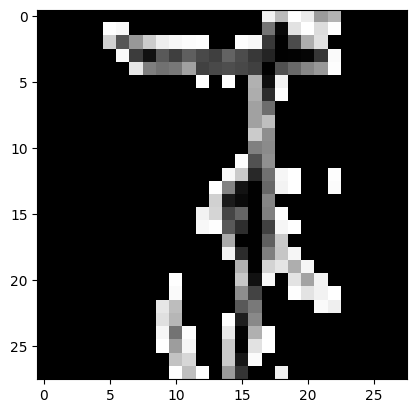

Input tensor shape for prediction: torch.Size([1, 1, 28, 28])
Prediction probabilities: tensor([[-18.3559,   3.7662,   9.7872,  10.8231,  -3.9964,   2.4199,   2.7715,
         -15.5202,  -1.7751,   0.6446]], device='cuda:0')
Predicted class: [3]


In [36]:
# Сохраняем произвольное число из датасета (тензор) в файл
timg = X_train[5]

# Поскольку X_train имеет размерность (60000, 28, 28), нам нужно добавить размерность для каналов
timg = timg.unsqueeze(0)

torch.save(timg, 'tensor.pt')

# Смотрим размер тензора - изображения
print("Saved image tensor size:", timg.size())

# И размер того, что изначально скармливали нейронке.
# Тензор подобного размера надо будет скормить нейронке для предсказания
print("Test tensor size:", X_test.size())
# Сохраняем модель с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)

# Загружаем модель, сохраненную в dill
with open("model.dill", "rb") as dill_file:
    modelp = dill.load(dill_file)

# Загружаем наше изображение
test_data = torch.load('tensor.pt')

# Смотрим, что пришло из dill файла
print("Loaded model:", modelp)

# Смотрим тип модели
print("Type of loaded model:", type(modelp))

# Переводим тензор на CPU для визуализации и убираем нормализацию
test_data_cpu = test_data.cpu().float()  # Убедитесь, что тензор типа float

# Удаляем размерность батча и каналов
test_data_cpu = test_data_cpu.squeeze(0).squeeze(0)

# Нормализуем данные для визуализации
test_data_cpu = test_data_cpu * 255  # Переводим в диапазон [0, 255]
test_data_cpu = test_data_cpu.byte()  # Преобразуем в тип byte

plt.imshow(test_data_cpu.numpy(), cmap='gray')
plt.show()

# Возвращаем тензор в тип float и масштабируем обратно в диапазон [0, 1]
test_data_cpu = test_data_cpu.float() / 255.0

# Добавляем размерность батча и каналов обратно
test_data = test_data_cpu.unsqueeze(0).unsqueeze(0)

# Проверяем
print("Input tensor shape for prediction:", test_data.shape)

# Проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Отправляем туда модель
modelp.to(dev)

# Тензор-изображение тоже
test_data = test_data.to(dev)

# Делаем предсказание
with torch.no_grad():  # Отключаем градиенты для предсказания
    preds = modelp(test_data)

# В каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print("Prediction probabilities:", preds)

# Выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(), axis=1)

# Смотрим, что предсказалось
print("Predicted class:", prediction)